<a href="https://colab.research.google.com/github/Yogendra-805/Finding-gender-bias-in-the-Hollywood-film-industry/blob/main/IDC409_MS19113_Project_01_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scrapping

In [ ]:
# Import Libreries.
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# Create empty list to store data.
movie = []
year = []
stars = []
director = []
gender = []


for i in range(1,101):
    url = "https://www.imdb.com/list/ls057823854/?sort=list_order,asc&st_dt=&mode=detail&page="+str(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    movie_data = soup.findAll('div', attrs = {'class': 'lister-item mode-detail'})
    for store in movie_data:
        try:
            m_name = store.h3.a.text

            year_of_release = store.h3.find("span", class_ = 'lister-item-year text-muted unbold').text.replace('(','').replace(')','')

            director_name =((store.findAll('p', class_="text-muted text-small"))[1].a).text

            star_names = (store.findAll('p', class_="text-muted text-small")[1]).findAll('a')
            for i in range(1,len(star_names)):
                try:
                    name = star_names[i].text
                    stars.append(name)
                    movie.append(m_name)
                    year.append(year_of_release)
                    director.append(director_name)

                    url1 = str("https://www.imdb.com")+star_names[i]['href']
                    response1 = requests.get(url1)
                    soup1 = BeautifulSoup(response1.content, 'html.parser')
                    actor_data = ((soup1.findAll('div', class_ = 'infobar'))[0].findAll('span', class_ = 'itemprop'))

                    gen = []
                    for i in range(len(actor_data)):

                        if (actor_data[i].text).replace('\n', '') == 'Actor' :
                            gender.append('M') 
                            gen.append('M')
                        if (actor_data[i].text).replace('\n', '') == 'Actress' :
                            gender.append('F')
                            gen.append("F")
                    if len(gen) == 0:
                        gender.append('Na')
                except IndexError:
                    pass
        except:
            pass

        
movie_df = pd.DataFrame(list(zip(movie, year, director, stars, gender )), columns = ["movie", "year", 'director', "stars", "gender"])

movie_df.to_csv('data.csv')

#  Analysis

In [ ]:
# import libraries.
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

In [ ]:
# read  the data.
data = pd.read_csv("data.csv")

## Data Cleaning 

In [ ]:
# drop the rows with unknown gender.
data.drop(data[data['gender'] == "Na"].index, inplace = True)

In [ ]:
# remove non numeric characters from year column.
data["year"] = data["year"].str.replace(r'\D', '', regex = True)

In [ ]:
# drop the empty rows.
data.drop(data[data['year'] == ""].index, inplace = True)

## Data Preprocessing 

In [ ]:
#create a dataframe of just actors and their gender
actor_gender_df = data[['stars','gender',]].copy()
actor_gender_df = actor_gender_df.drop_duplicates()
actor_gender_df

,stars,gender
0,John Travolta,M
1,Uma Thurman,F
2,Samuel L. Jackson,M
3,Bruce Willis,M
4,Andrew Garfield,M
...,...,...
38452,Ryoko Seta,M
38456,Clark Sarullo,M
38459,Chiara Aurelia,M
38460,Carel Struycken,F


In [ ]:
gender_counts = actor_gender_df["gender"].apply(pd.value_counts).count()

In [ ]:
gender_counts

M    10530
F     6838
dtype: int64

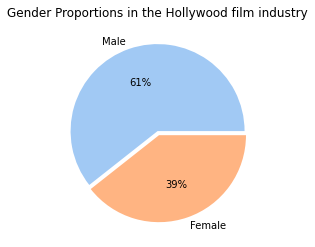

In [ ]:
# Ploting
palette_color = seaborn.color_palette('pastel')
plt.pie(gender_counts, labels=["Male", "Female"], colors = palette_color,
        explode=[0,0.05], autopct='%.0f%%')
plt.title("Gender Proportions in the Hollywood film industry")
#plt.savefig("file1.png")
plt.show()

## Gender Proportions from 1964 to 2027

In [ ]:
#create df of movie year and actor gender for each movie
actor_year = data[['year','gender']].copy()

In [ ]:
actor_year.head()

,year,gender
0,1994,M
1,1994,F
2,1994,M
3,1994,M
4,2014,M


In [ ]:
#group by year and gender
act_gen_df = actor_year.groupby(['year', 'gender']).size().to_frame().unstack()

In [ ]:
#flattens column headers
act_gen_df.columns = act_gen_df.columns.get_level_values(1)

In [ ]:
#creates total column
act_gen_df["total"] = act_gen_df.sum(axis=1)

In [ ]:
#creates male percent column
act_gen_df['male_percent'] = act_gen_df['M'] / act_gen_df['total']

In [ ]:
#creates female percent column
act_gen_df['female_percent'] = act_gen_df['F'] / act_gen_df['total']

In [ ]:
act_gen_df.head()

gender,F,M,total,male_percent,female_percent
year,,,,,
1964,1.0,3.0,4.0,0.750000,0.250000
1967,NaN,4.0,4.0,1.000000,NaN
1970,18.0,21.0,39.0,0.538462,0.461538
1971,6.0,12.0,18.0,0.666667,0.333333
1972,93.0,154.0,247.0,0.623482,0.376518


In [ ]:
#creates new df without female, male, total columns to make it easier to plot
act_gen_plot = act_gen_df.drop(columns=['F', 'M', 'total'])

In [ ]:
#renames columns
act_gen_plot.rename(columns = {'female_percent':'female', 'male_percent':'male'}, inplace=True)

In [ ]:
#convert decimals to percent
act_gen_plot = act_gen_plot * 100

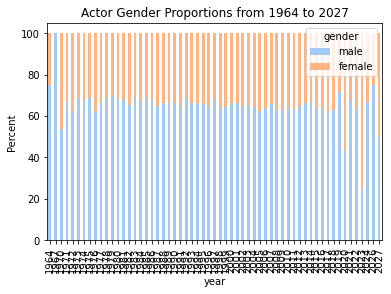

<Figure size 432x288 with 0 Axes>

In [ ]:
#actor gender each year plot
act_gen_plot.plot.bar(stacked=True, color = palette_color)
plt.ylabel('Percent')
plt.title('Actor Gender Proportions from 1964 to 2027')
plt.show()
#plt.savefig("file2.png")